In [9]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
import pennylane as qml

# Pennylane numpy
import pennylane.numpy as pnp

In [10]:
# ==============================
# Setup for Quantum Computations
# ==============================
# PennyLane settings
coeffs = [-0.5]
obs = [qml.PauliZ(0)]
hamiltonian = qml.Hamiltonian(coeffs, obs)
dev = qml.device('default.mixed', wires=1)

In [11]:
# Global Variables
Tau_global = 5e-2   # Dephase tau
Paras_global = pnp.zeros(2)
Phi_global = 0
Gamma_ps = 0

class DataIndex(Enum):
    BEFORE = 0
    PHI = 0
    CFI = 1
    PARAS = 2
    THETA_X = 2
    PHI_Z = 3


In [12]:
def Dephase_factor(tau):
    """
    Calculate the dephasing factor (gamma) based on the provided tau value.

    Args:
        tau (float): Dephasing time constant.

    Returns:
        float: Calculated dephasing factor (gamma).
    """
    return 1 - np.exp(-2 * tau)

$$
\rho_{After_Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-t} = \sqrt{1 - \gamma}
$$

In [13]:
@qml.qnode(dev)
def circuit(phi):
    global Tau_global, Paras_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = Paras_global

    qml.RX(pnp.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

In [14]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global = paras
    phi = pnp.array([Phi_global])    
    
    CFI = qml.qinfo.classical_fisher(circuit)(phi[0])
    return -CFI

In [15]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(sweep_data, initial_parameters, gamma_ps, iterations):
    """ 
    Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        sweep_data (tuple): (start, end, step) values for the sweep.
        initial_parameters (numpy_array): Array of parameters for the qnode.
        gamma_ps (int): The Gamma value for post-selection.
        iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array containing phi, CFI, and optimized parameters.
    """
    
    # Create Data array
    PHI = np.arange(sweep_data[0], sweep_data[1], sweep_data[2])
    Data = np.zeros((iterations + 1, len(PHI), len(initial_parameters) + 2)) 
    Data[:, :, DataIndex.PHI.value] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Store initial CFI data and parameters
    for idx, phi in enumerate(PHI):
        Data[DataIndex.BEFORE.value][idx][DataIndex.CFI.value] = -Cost_function(initial_parameters)
        Data[DataIndex.BEFORE.value][idx][DataIndex.PARAS.value:] = initial_parameters
        
    # Optimize begin
    for iteration in range(1, iterations + 1):
        for phi_idx, phi_current in enumerate(PHI):
            # Determine initial parameters based on the iteration
            if iteration == 1:
                Paras_Temporary = initial_parameters
            else:
                Paras_Temporary = Data[iteration][phi_idx][DataIndex.PARAS.value:]
            
            # Update the global Phi value
            Phi_global = phi_current
            
            # Determine constraints
            Constraints = get_constraints(phi_current)
                
            # Optimize the data
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(
                Cost_function, 
                Paras_Temporary, 
                method = 'L-BFGS-B', 
                bounds = Constraints,
                # options={'maxiter': 16000*10}
            )
            
            Data[iteration][phi_idx][DataIndex.CFI.value] = -Result_BFGS.fun
            Data[iteration][phi_idx][DataIndex.PARAS.value:] = Result_BFGS.x
            
    return Data

def get_constraints(phi_current):
    # # N = (int(phi_current / np.pi) + 1)  
    # N = np.pi * int(phi_current / np.pi)
    # if ((phi_current < (1.43 + N)) or (phi_current > (1.78 + N))):
    #     return [(0, 3*np.pi/2)] * 2
    # else:   # Side by side pi/2(=1.43 ~ 1.78)
    #     return [(-float('inf'), float('inf'))] * 2 
        # return [(-np.pi, np.pi*2)] * 2 
        # return [(-np.pi*2, np.pi*3)] * 2 
    
    return [(-float('inf'), float('inf'))] * 2 
    # return [(-np.pi*2, np.pi*3)] * 2 

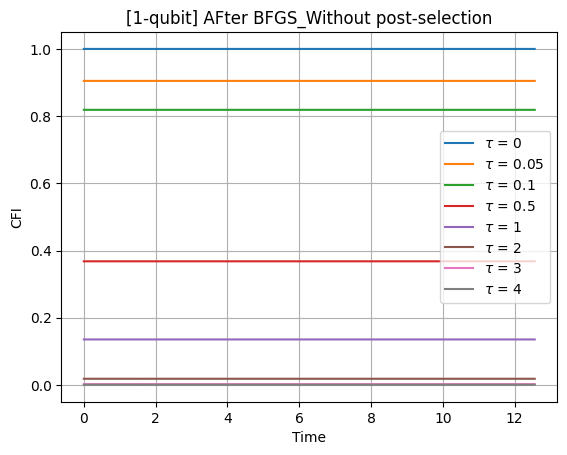

In [16]:
# tau_plot = 5e-1, 
tau_plot = 0, 5e-2, 1e-1, 5e-1, 1, 2, 3, 4
# tau_plot = 3, 4

Sweep_data = np.array([0, np.pi*4, 1e-2])  #1e-2 ~ (4pi + 1e-2)
Sweep_data_arange = np.arange(Sweep_data[0], Sweep_data[1], Sweep_data[2])

Para_store = np.zeros((len(tau_plot), len(Sweep_data_arange), 2))

for idx,tau_current in enumerate(tau_plot):
    Tau_global = tau_current
    
    Paras_init = pnp.zeros(2)
    Paras_init[:2] = np.pi/2

    Gamma_ps_preset = 8e-1
    Set_Iterations = 1
    
    Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)
    
    Para_store[idx][:, 0] = Optimized_Result[Set_Iterations][:,DataIndex.THETA_X.value]
    Para_store[idx][:, 1] = Optimized_Result[Set_Iterations][:,DataIndex.PHI_Z.value]
    
    plt.plot(Sweep_data_arange, Optimized_Result[1][:, DataIndex.CFI.value], label = f'$\\tau$ = {tau_current}')
    
plt.title(f'[1-qubit] AFter BFGS_Without post-selection')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()

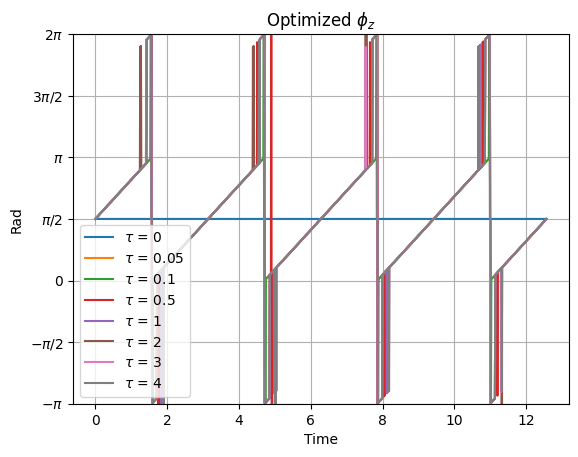

In [22]:
for idx, tau in enumerate(tau_plot):
    # if idx, tau != 4:
        plt.plot(Sweep_data_arange, Para_store[idx][:, 1], label = f'$\\tau$ = {tau}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
# plt.yticks([-np.pi, 0, np.pi, 2*np.pi], ['$-\pi$', '0', '$\pi$', '$2\pi$'])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-np.pi, 2*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

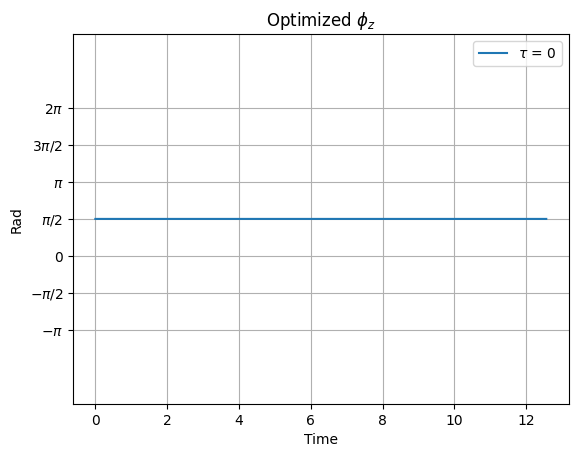

In [17]:
slice = int(len(Sweep_data_arange) / 1)

tau_order = 0,

for idx, tau in enumerate(tau_order):
    plt.plot(Sweep_data_arange[:slice], Para_store[tau][:slice, 1], label = f'$\\tau$ = {tau_plot[tau]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-2*np.pi, 3*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [18]:
# indices = np.where(Para_store[1][:, 1] <= 2e-1)
indices = np.where(Para_store[0][:, 1] > (1*np.pi))

indices

(array([], dtype=int64),)

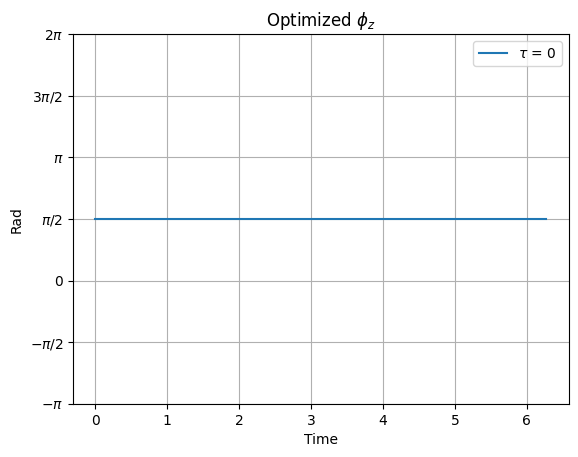

In [19]:
slice = int(len(Sweep_data_arange) / 2)

tau_order = 0,

for idx, tau in enumerate(tau_order):
    plt.plot(Sweep_data_arange[:slice], Para_store[tau][:slice, 1], label = f'$\\tau$ = {tau_plot[tau]}')

# Set the yticks to be at -2π, -π, 0, π, and 2π
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.ylim(-np.pi, 2*np.pi)

plt.title(f'Optimized $\\phi_{{z}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()

In [20]:
# indices = np_.where(Para_store[1][:, 1] <= 2e-1)
indices = np.where(Para_store[0][:, 1] <= np.pi)

indices

(array([   0,    1,    2, ..., 1254, 1255, 1256]),)

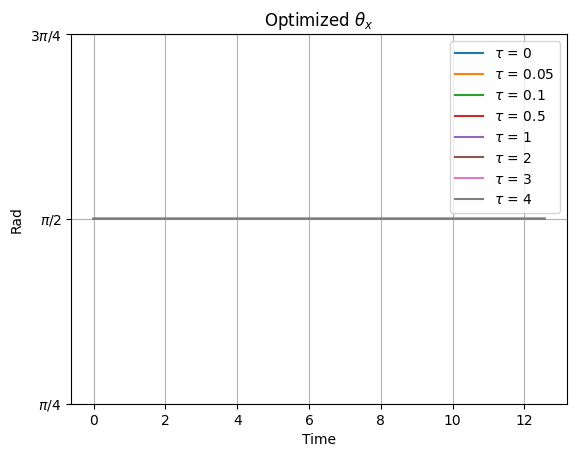

In [21]:
for idx, tau in enumerate(tau_plot):
    plt.plot(Sweep_data_arange, Para_store[idx][:, 0], label = f'$\\tau$ = {tau}')

# Set the yticks to be at π/4, π/2, and 3π/4
plt.yticks([np.pi/4, np.pi/2, 3*np.pi/4], ['$\pi/4$', '$\pi/2$', '$3\pi/4$'])

plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('Rad')
plt.grid()
plt.legend()

plt.show()